# Assignment 2

Use this notebook to write your code for assignment 2

# Pre-processing data

Read the data file of `shakespeare.txt` and prepare the inputs/outputs to your model.

In [1]:
import unidecode
import string
import random
import re
import torch
import torch.nn as nn
from torch.autograd import Variable
import time, math

In [2]:
all_characters = string.printable # list of all possible characters (from string)
num_characters = len(all_characters) # number of possible characters

text = unidecode.unidecode(open('./data/shakespeare.txt').read())

text_len = len(text) 

sequence_len = 40

def generate_sequence():
    start_index = random.randint(0, text_len - sequence_len)
    end_index = start_index + sequence_len + 1
    return text[start_index:end_index]


# Build the Model

Implement a character-based LSTM model 

In [3]:
class CharNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(CharNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers)
        
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.lstm(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self): 
        return (torch.zeros(1, 1, self.hidden_size),
                torch.zeros(1, 1, self.hidden_size))

In [4]:
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)


# Training

The main training routine

In [5]:
def generate_training_set():    
    
    sequence = generate_sequence()
    inp = char_tensor(sequence[:-1])
    target = char_tensor(sequence[1:])
    
    return inp, target

In [6]:

def evaluate_CharNN(character_seed='A', predict_len=100, temperature=0.8):
    
    hidden = decoder.init_hidden()
    seed_input = char_tensor(character_seed)
    predicted_string = character_seed

    for p in range(len(character_seed) - 1):
        _, hidden = decoder(seed_input[p], hidden)
    inp = seed_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        output_distribution = output.data.view(-1).div(temperature).exp()
        top_character = torch.multinomial(output_distribution, 1)[0]
        predicted_char = all_characters[top_character]
        predicted_string += predicted_char 
        inp = char_tensor(predicted_char) 
        
    return predicted_string

In [7]:

def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()

    loss = 0

    for c in range(sequence_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, torch.LongTensor([target[c]]))

    loss.backward()
    decoder_optimizer.step()

    return loss.data.item() / sequence_len

In [8]:
def runtime(instant):
    seconds = time.time() - instant
    minutes= math.floor(seconds / 60)
    seconds -= minutes * 60
    return '%dm %ds' % (minutes, seconds)

In [9]:
num_epochs = 3000
print_every = 500 
plot_every = 10 
hidden_size = 200
num_layers = 1
learning_rate = 0.005

decoder = CharNN(num_characters, hidden_size, num_characters, num_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = [] 
loss_avg = 0

for epoch in range(1, num_epochs + 1):
    loss = train(*generate_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[Runtime: %s, Epoch: %d (%d%%), Loss: %.4f]' % (runtime(start), epoch, epoch / num_epochs * 100, loss))
        print(evaluate_CharNN('Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every) 
        loss_avg = 0

[Runtime: 0m 16s, Epoch: 500 (16%), Loss: 2.0215]
Whonteng delles sume,
Oar thung or peares came hour chil, love untine fueYes thol mute,
But Juer hour  

[Runtime: 0m 34s, Epoch: 1000 (33%), Loss: 2.1039]
Whrean speven ell priren by grich tire sing that in grace when slet with thich hast the dron wop in me 

[Runtime: 0m 58s, Epoch: 1500 (50%), Loss: 1.9108]
Whis of thou here ar thy of shou hines anter thy vitons lat as those his growher here didery shoult,
S 

[Runtime: 1m 14s, Epoch: 2000 (66%), Loss: 2.1506]
Whiched bright be iste love this doth in the of your farts,
So spire you the conts,
And by sweach will 

[Runtime: 1m 30s, Epoch: 2500 (83%), Loss: 2.0869]
Which a deack mares meass and thand, the should in hear pen ast is what stang the one the the quith op 

[Runtime: 1m 47s, Epoch: 3000 (100%), Loss: 1.3332]
When giers to light gath's othered ows lar,
To to then the and nothe'l to and by in mold,
For with to  



# Plotting the Training Losses

Plotting the historical loss during training:

Text(0, 0.5, 'Loss')

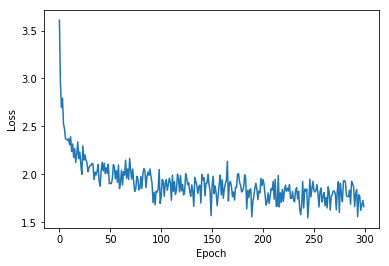

In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

# Plot Loss function using "all_losses"
plt.figure()
plt.plot(all_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')


# Evaluating at different "temperatures"

Changing the `temperature` argument (variance) for 1.5, 0.75. 0.25 and sample outputs from the trained model.

In [11]:
print(evaluate_CharNN('Shall I compare thee to a summer''s day?\n', 300, temperature=1.5))

Shall I compare thee to a summers day?
Timbt of lsee:'Buf.
Ornd I I liapt,
  To willy.


         heave,
Anaide
Being koed
Filly r, wioute
Foor my kighn<s,
Alt tell,,
S t they if own,leeforalapple:
 alyirhoo'pord I je,
Arly, ise.
  Azingn.
(Leat.

hy giver bovoure, have!,
Href lipty teast-ijpaindoving mene pyey:
Ressementers?
AMte tobine


In [12]:
print(evaluate_CharNN('Shall I compare thee to a summer''s day?\n', 300, temperature=0.75))

Shall I compare thee to a summers day?
Or name of this bliught the love soirs selfoul stils proved
And be,
Thouswing the prate, break's the dent,
Nampite
My so removen thee, and the better in breat for thee ir there time,
And dever, and the dest thou so my brehose temies to brost doth to all of the rose I beate,
Thou ear strear sast of a


In [13]:
print(evaluate_CharNN('Shall I compare thee to a summer''s day?\n', 300, temperature=0.25))

Shall I compare thee to a summers day?
The the the so beauty beauty seem the beauty breake the so be the see the with the so be be the the beauty beauty the beauty beauty so my breake the beauty and beauty proved the so grace,
And the beauty be beauty beauty seem the so the beauty beauty beauty seem the breat the best the beauty beauty b
